In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import os
result_dir = 'results'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

In [2]:
MAX_NUM_SAMPLES = 5
BATCH_SIZE = 512
EPOCH = 15
INPUT_SIZE = 28*28
HIDDEN_SIZE = 256
NUM_CLASS = 10
LEARNING_RATE = 1e-3

In [3]:
import os
from pathlib import Path
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from datasets import DigitSelection
DATASET_PATH = os.environ.get('DATASET_PATH')
if DATASET_PATH is None: 
    DATASET_PATH = './data'
    os.makedirs(DATASET_PATH, exist_ok=True)

mnist_train = MNIST(DATASET_PATH, train=True, transform=transforms.ToTensor(), download=True)
mnist_test = MNIST(DATASET_PATH, train=True, transform=transforms.ToTensor(), download=True)
digit_train = DigitSelection(mnist_train, MAX_NUM_SAMPLES)
digit_test = DigitSelection(mnist_test, MAX_NUM_SAMPLES)
train_loader = DataLoader(digit_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(digit_test, batch_size=BATCH_SIZE)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Largest target Label is  5


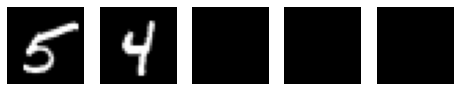

In [5]:
def plot_dataset(dataset):
    (x, condition), y = dataset[0]
    f, axarr = plt.subplots(1, MAX_NUM_SAMPLES, figsize=(8, 8))
    for i in range(MAX_NUM_SAMPLES):
        axarr[i].imshow(x[i,0,:].numpy(), cmap='gray')
        axarr[i].set_axis_off()
    print("Largest target Label is ", y)
    plt.show()

plot_dataset(digit_train)

In [6]:
from model import AttentionSelectionModel
from modules import DotScore
model = AttentionSelectionModel(INPUT_SIZE, HIDDEN_SIZE, NUM_CLASS, DotScore(HIDDEN_SIZE))
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [7]:
from sklearn.metrics import accuracy_score
from trains import GeneralTrainer
trainer = GeneralTrainer(model, lambda:torch.optim.AdamW(model.parameters()), nn.CrossEntropyLoss(), score_metric={'accuracy':accuracy_score})
trainer.set_tqdm(True)

In [8]:
result = trainer.train(train_loader, val_loader=test_loader, epochs=EPOCH, device=device)
trainer.save_data(os.path.join(result_dir, "sel_digits_{}_adamW_{}".format(EPOCH, LEARNING_RATE)))

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

training:   0%|          | 0/118 [00:00<?, ?it/s]

validating:   0%|          | 0/118 [00:00<?, ?it/s]

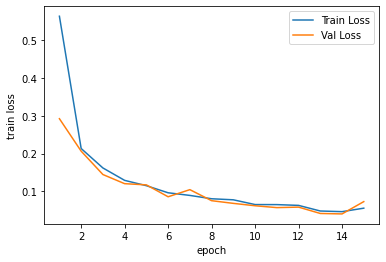

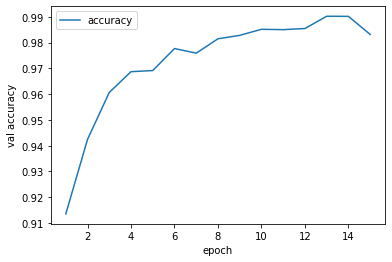

In [9]:
sns.lineplot(x='epoch', y='train loss', data=result, label='Train Loss')
sns.lineplot(x='epoch', y='val loss', data=result, label='Val Loss')
plt.show()
sns.lineplot(x='epoch', y='val accuracy', data=result, label='accuracy')
plt.show()

In [10]:
trainer.load_data(os.path.join(result_dir, "sel_digits_{}_adamW_{}".format(EPOCH, LEARNING_RATE)))
result = trainer.get_result()

Largest target label is 8 and predicted lable is 8


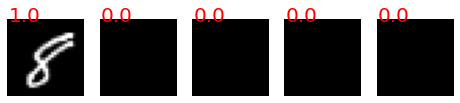

Lowest target label is 1 and predicted lable is 1


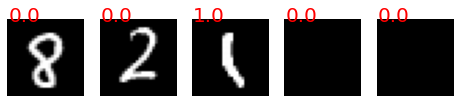

Largest target label is 9 and predicted lable is 9


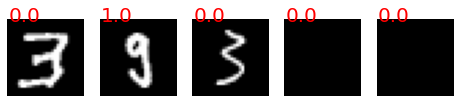

In [12]:
def plot_result_with_weights(x, condition, y, pred_y, weights):
    x = x.cpu()
    f, axarr = plt.subplots(1, MAX_NUM_SAMPLES, figsize=(8, 8))
    for i in range(MAX_NUM_SAMPLES):
        axarr[i].imshow(x[i,0,:].numpy(), cmap='gray')
        axarr[i].text(0.0, 0.5, str(round(weights[i],2)), dict(size=20, color='red'))
        axarr[i].set_axis_off()
    print(f'{"Largest" if condition.item() == 0 else "Lowest"} target label is {y} and predicted lable is {pred_y.cpu().item()}')
    plt.show()       

from utils import to_device
x, y = next(iter(test_loader))# Select a data point (which is a bag)
x = to_device(x, device)
with torch.no_grad():
    pred_y = model(x)
    weights = model.weights
    weights = weights.squeeze(-1).cpu().numpy()
    pred_y = torch.argmax(pred_y, dim=1)

for i in range(3):
    plot_result_with_weights( x[0][i], x[1][i], y[i], pred_y[i], weights[i])